In [1]:
from IPython.display import Latex, Math
from IPython.display import Image

In [2]:
import json

import numba
import numpy as np
import pandas as pd
from scipy.stats import linregress

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [3]:
plt.rc('font', size = 12)

# Hashing accelerated segmentation of timeseries


In this blog post, we are going to investigate a possible way to speed up segmentation of time series. A time series is an ordered sequence of elements. A segment is a region of the timeseries where the observations are similar according to some measure. The aim is to identify these regions.

## Preliminaries

### Basic definitions

#### Time series

Let us assume we have a time series, $F$. We can formally define it as

$$
\begin{eqnarray}
& &! N \in \mathbb{N}, N > 1           
\quad  &\textit{(length of the timeseries)}\\
& &\mathbb{I} \subseteq \mathbb{N}, \forall i \in \mathbb{I}: 0 < i \leq N 
\quad &\textit{(indices of the time series elements)}\\
& & ! f \in \mathbb{X} \rightarrow \mathbb{Y}  
\quad &  \textit{(underlying function of timeseries)}\\
& & \forall i, j \in \mathbb{I}: i < j \land \forall x_{i}, x_{j} \in \mathbb{X}  \implies x_{i} < x_{j} \quad &\textit{(ordering)} \\
& & !F := \{f_{i} := \big(i, f(x_{i})\big), i \in \mathbb{I} \}   
\quad & \textit{(timeseries as a set of ordered pairs)}
 \end{eqnarray}
$$

#### Segmentation

A segmentation, $S$ is the division of the time series, $F$ to non overlapping sequences.

$$
\begin{eqnarray}
& &! K \in \mathbb{N}, 0 < K \leq N 
\quad & \textit{(number of segments)}   \\
& &\mathbb{K} \subseteq \mathbb{N}, \forall k \in \mathbb{K}: 0 < k \leq K 
\quad &\textit{(indices of the segments)}\\
& &S_{k} \subseteq F 
\quad & \textit{(part of the timeseries)} \\
& & |S_{k}| > 0 \quad & \textit{(not empty)}   \\
& & \forall |S_{k}| > 1: \, \forall \, f_{i} \, \exists j, j \neq i: \,  f_{j} \in S_{k} \, \land \, |i-j| = 1
\quad & \textit{(subsequent time series elements in a segment)}\\
& & \forall k < l \in \mathbb{K} : \, \, \forall f_{i} \in S_{k}, \forall f_{j} in S_{l} : i < j
\quad & \textit{(segments are ordered)} \\
& &\forall k,l: S_{k} \cap S_{l} = \emptyset
\quad & \textit{(therefore they do not overlap)}\\
& & S = \bigcup\limits_{k = 1}^{k} S_{k} 
\quad & \textit{(segmentation is the collection of segments)}
\end{eqnarray}
$$

The set of all segmentations will be denoted as $\mathbb{S}$.

#### Loss function

The goodness of the segmentation is measured by a loss function, L which is the function of the timeseries and the segmentation. 

$$
L \in (f, \mathbb{S}) \rightarrow \mathbf{R}
$$

A segmentation is said to be optimal if it minimises the loss function. The optimal parition will be denoted by $S^{*}$. The problem is to find this parition:

$$
S^{*} = \underset{S \in \mathbb{S}}{\operatorname{argmin}}  L(f, S)
$$

So good, so far. In the following, it will be shown that some segmentations and loss functions can be defineined in a way that offers the possibility of speeding up the optimisation process.

### Special components and requirements

#### Additive loss function

We now make a serious requirement on the loss function. It is required to be additive over the segments of a particular segmentation:
$$
L(f, S) = \sum\limits_{k=1}^{K} L_{k}(f,S_{k}) 
$$

#### Fixed length blocks

The time series is segmented to a sequence fixed length blocks, $\{B_{1}, B_{2}, ..., B_{N_{b}} \} = B \in \mathbb{S}$.  The membership of the blocks do not change in the following. The blocks are chosen according to some assumptions. For example, each block has if of approximately the same length, of some property of interest is constant in a block.

#### Binary encoding

A segmentation, $S$ can be constructed using the blocks defined above.

The relationship between two adjacent blocks, $B_{i}, B_{i+1}, 0 < i < |B|$ can be represented by a binary variable, $c_{i}$. $c_{i}$ is unit if the $i$-th block is the same segment as the $i+1$-th.
$$
c_{i} = 
\begin{cases}
1, \, \, \text{if} \,\, B_{i} \subseteq S_{k} \land B_{i+1} \subseteq S_{k}\\
0, \,\,\text{else}
\end{cases}
$$

Therefore every segmentation constructed from  $N_{b} = |B|$ blocks can be represented by a binary string of length $N_{b} - 1$.For example, if we have five blocks the (1,2)(3,4,5) partition can be represented as **1011**. 

#### Hashing

Every solution constructed from the blocks is thus can be represented by a string. Each string can be broken down to segments consisting connected blocks. The string **1011** can be written as **1 + (0) + 11**. For the loss function is additive the segments, total loss will be the sum of the partial losses associated with each substring.

$$
F\big(((1,2),(3,4,5))\big) = F(1xxx) + F(xx11)
$$

There is a fixed number of connected block arrangements or patterns.

$$
N_{p} = \frac{(N_{b}+1)N_{b}}{2}
$$

For example for a five block long string:

$$
\begin{aligned}
& \text{two-block:}  \,  1xxx , x1xx, xx1x, xxx1, \\
& \text{three-block:} \, 11xx , x11x, xx11, \\
& \text{four-block:}  \, 111x , x111, \\
& \text{five-block:}  \, 1111 , \\
& \text{standalone block:}        \, 00xx , x00x, xx00, xxx0
\end{aligned}
$$

where **x** does not contribute to the loss function, and **00** signifies a standalone block. Each of these patterns has a loss value which can be computed and stored in hash table. 

#### Evaluating the loss function from a hash table

Whenever a segmentation is encountered it is broken down to patterns. The values of those patterns are looked up from the hash table. These values are then summed which returns the value of the loss function.

#### Summary

To recap: the solution space is large $2^{N_{b}-1}$ which can be covered with the combinations of patterns. The number of patterns is $\frac{(N_{b}+1)N_{b}}{2}$. To put it in context, if there are 21 blocks, $2^{20} \approx 1,000,000$ solutions exist. The entire loss function space can be covered with the combination $21 \times 22/2 = 231$ hashed values.

## Algorithms and implementation

### General algorithm

The general algorithm can be divided to two subalgorithms according to their concerns. Firstly, the hash table has to be **prepared**. The **evaluation** takes place inside an optimisation algorithm of the user's choice.

**Preparation**
1. Define timeseries
1. Specify number of blocks
1. Divie timeseries to blocks
1. Define loss function 
1. Generate all patterns
1. Calculate hash of patterns and the associcated loss
1. Hash the above values

**Evaluation**
1. Generate a segmentation on the basis of blocks
1. Decompose the segmentation to blocks
1. Look up pattern loss values from hash table
1. Sum up pattern losses

#### Construction of hash table

Firstly, we choose the number of blocks, $N_{b}$, and divide the series, $f$ to blocks. Then all possible patterns (1xx, x1x, etc...), $\mathbb{P}$ are generated. The hash keys of the patterns are calculated. The cost of merging the blocks to patterns,  $\texttt{MergeCost}$, are calculated too and saved in the hashtable, _HashTable_ at the corresponding hash key. This algorithm is implemented  as the `create_table` method of `HashBrown` class.

 $$
\begin{eqnarray}
&   &  \textbf{Algorithm:} \, \texttt{Construct Hash Table} \\
&0.\, &  \quad \texttt{ConstructHashTable}(f, N, \texttt{MergeCost)} \\\
&1.\, &  B = \{b_{1}, b_{2}, ... b_{N} \} \leftarrow f \\
&2.\, & HashTable \leftarrow {:} \\
&3.\, & \textbf{For} \, p \in \mathbb{P} \\
&3.1   & \quad       w \leftarrow \texttt{MergeCost}(p) \\
&3.2   & \quad       h \leftarrow \texttt{Hash}(p) \\
&3.3   & \quad  HashTable(h) \leftarrow w \\
&4.\, & \mathbf{return} \, HashTable
\end{eqnarray}
$$

#### Evaluation of the loss function

The loss function is evaluated for a certain segmentation, $S$ in the following way. The segmentation is decomposed to patterns. The hash of each pattern is calculated. Finally the values are looked up from the hash table, _HashTable_. The sum of the values returns the loss function at the segmentation.

 $$
\begin{eqnarray}
&   &  \textbf{Algorithm:} \, \texttt{Calculate Loss Function} \\
&0.\, &  \quad \texttt{LossFunction}(S, HashTable) \\
&1.\, & W \leftarrow 0 \\
&2.\, & hashes \leftarrow \texttt{Translate}(S) \\
&3.\, & \textbf{For} \, h \in hashes \\
&3.1   & \quad       w \leftarrow HashTable(h) \\
&3.2   & \quad       W \leftarrow W + w \\
&4.\, & \mathbf{return} \, W
\end{eqnarray}
$$
 
#### Translation of segmentations to set of hash keys

As a first step the segmentation is decomposed to a sequence of patterns. Each pattern is encoded by its position and length, $(p, l)$. For example, 11100110110 would be (0,3), (4,0) (6,2), (8,2) (9,0). These doublets can be used as keys in the hash table right away, or they can be converted to integers. This is a choicee between the cost of hashing tuples, and cost of converting to integer and using an integer as a hash key (in python, the hash of a positive integer is itself).

##### Hash function

We choose to use an integer hash function, `calculate_pattern_hash`. For a given position, $p$, length, $l$ and number of blocks, $N_{b}$ the hash is

$$
\texttt{Hash}(p, l; N_{b}) = \frac{(l-1)\cdot  (2 \cdot N_{b} - (l -2))  }{2} + p \, .
$$
 

In [4]:
@numba.jit(nopython = True)
def calculate_pattern_hash(pattern_spec, arrlen):
    """
    Parameters:
        pattern ((int,int)) : the position and length of a pattern
        arrlen (int) : length of binary encoding array (number of blocks - 1)
    Returns:
        hash_ (int) : the hash of the pattern
    """
    
    pos, length = pattern_spec

    hash_ = (length - 1) * (2 * arrlen - (length - 2)) // 2 + pos
        
    return hash_

##### Decomposition

The decompostion of a segmentation is implemented in the `translate_segmentation` function.
$$
\begin{eqnarray}
&   &  \textbf{Algorithm:} \, \texttt{Translate} \\
&0.\, &  \quad \texttt{Translate}(S) \\
&1.\, & \mathbb{H} \leftarrow \emptyset \\
&2.\, & positions, lengths \leftarrow S \\
&3.\, & \textbf{For} \, p, l \in (positions, lengths) \\
&3.1   & \quad       h \leftarrow Hash(p, l) \\
&3.2   & \quad       \mathbb{H} \leftarrow \mathbb{H} \cup \{h\} \\
&4.\, & \mathbf{return} \, \mathbb{H}
\end{eqnarray}
$$

##### Loss function

The loss function, `calculate_loss_function` is a simple sum over the table lookup values.

In [5]:
def calculate_loss_function(segmentation, store, hash_table):
    """
    Calculates the additive loss function.
    Parameters:
        segmentation (np.ndarray) : binary array representing a segmentation
        store (np.ndarray) : array to store calculated hash keys
        hash_table ({int:float}) : hash table encoding the pattern values
    Returns:
        loss (float) : the value of the loss function at segmentation
    """
    
    hash_keys = translate_segmentation(segmentation, store)
    loss = sum(hash_table[k] for k in hash_keys)
    
    return loss

#### Translation

The `translate_segmentation` function translates the binary string representation to a sequence of hash keys. This function is called at the evaluation of a segmentation in the loss function.

The number of blocks is agian denoted by $N_{b}$. The standalone blocks have the first $N_{b}$ keys. The other pattern keys are sorted according to their length and position. The has keys therefore the integers in the 0, $$N_{b}$ \cdot ($N_{b}$ + 1) / 2$ range.

The function is compiled at first call. The hash function is inlined. Also, the array which would contain the sequence of hash keys is passed as a parameter, so that it need not be allocated at each call. These are done in order to speed up the routine.

In [6]:
@numba.jit(nopython = True)
def translate_segmentation(arr, store):
    """
    Translates a binary string representation of a segmentation
    to a list of hash keys.
    Parameters:
        arr (np.ndarray of 0 and 1): binary representation of a segmentation
        store (np.ndarray) : storage for hash keys
    Returns:
        store (np.ndarray) : section of store updated with the new hash keys
    """
    
    is_free = True
    length = 1
    iseg = -1
    arrlen = arr.size + 1
    
    for i, x in enumerate(arr):
        
        if x == 1:
            if is_free:
                pos = i
                is_free = False
            length += 1
        else:
            # end of subsequent ones
            if length > 1:
                hash_ = calculate_pattern_hash((pos, length), arrlen)
                length = 1
                is_free = True
            
            # add zeros
            else:
                hash_ = i
                
            iseg += 1
            store[iseg] = hash_               
    
    # last element
    if length > 1:
        hash_ = calculate_pattern_hash((pos, length), arrlen) 
    else:
        hash_ = i + 1
        
    iseg += 1
    store[iseg] = hash_
      
    return store[:iseg + 1]

#### Helper functions

The `calculate_block_indices` function creates a list of indices which delimit the blocks. It is used in the `HashBrown` class.

In [7]:
def calculate_block_indices(series, n_blocks):
    """
    Calculates the left and rightmost indices of the blocks.
    Parameters:
        series (np.ndarray)
        n_blocks : number of blocks
    Returns:
        block_indices (np.ndarray) : the delimiting indices of the blocks.
    """
    
    if n_blocks > series.shape[1]:
        raise IndexError("Number of blocks exceeds length of array.")

    block_indices = [(idcs[0], idcs[-1]) for idcs in np.array_split(np.arange(series.shape[1]), n_blocks)]
    block_indices = np.array(block_indices, dtype = np.int)

    return block_indices

### Implementation

All these utilities are stored in the class `HashBrown`. It is avaialable as a `python` module [here]().

In [8]:
class HashBrown(object):
    """
    Class to create a hash table for block merging time series.
    
    Attributes:
        n_blocks (int) : number of blocks
        series (np.ndarray) : the underlying timeseries
        table ({:}) : hash table of the merge costs. 
    
    Methods:
        create_pattern_generator() : returns a generator object of the patterns. 
        Each element is tuple of position and length of the pattern in ascending order.
        create_table() : creates a hash table using the merge cost and hash function 
    """
    
    @property
    def n_blocks(self):
        return self._n_blocks
   
    @property
    def series(self):
        return self._series
    
    @property
    def table(self):
        return self._table
    
    def __init__(self, series, n_blocks, 
                    func, hfunc, 
                    func_args = [], func_kwargs = {},
                    hfunc_args = [], hfunc_kwargs = {}):
        """
        n_blocks (int) : number of blocks
        func (callable) : cost of merging blocks to a pattern
        func_args ([]) : arguments of func
        func_kwargs({:}) : keyword arguments of func
 
        hfunc (callable) : hash function
        hfunc_args ([]) : arguments of hfunc
        hfunc_kwargs({:}) : keyword arguments of hfunc  
        """
        self._series = series
        
        self._n_blocks = n_blocks
        self._string_length = self.n_blocks - 1
        
        # cost function
        self._func = func
        self._func_args = func_args
        self._func_kwargs = func_kwargs
   
        # hash function
        self._hfunc = hfunc
        self._hfunc_args = hfunc_args
        self._hfunc_kwargs = hfunc_kwargs
        
        # hash table
        self._table = None

    def create_pattern_generator(self):
        """
        Creates a generator of patterns. The generator itself is a sequence
        of (position, length) tuples.
        Example: (0,1), (1,1), (2,1), ..., (0,2), (1,2), ...
        """
        
        pattern_generator = ((i_start, i_end + 1) for i_end in range(self._n_blocks) 
                                for i_start in range(self._n_blocks - i_end))
        
        return pattern_generator

    def create_table(self):
        """
        Creates a hash table of the merge costs of patterns.
        The key is the integer hash of the pattern.
        The value is the merge cost of that pattern.
        """
         
        # create iterator
        patterns = self.create_pattern_generator()
        
        # populate table
        table = {self._hfunc(pattern, *self._hfunc_args, **self._hfunc_kwargs) :
                 self._func(pattern, self._series, *self._func_args, **self._func_kwargs)
                     for pattern in patterns}
        
        self._table = table

#### Loss function

The loss function at a particular segmentation is calculated in two steps. The segmentation is translated to a sequence of hash keys. The values at these keys are looked up and summed.

In [9]:
def calculate_loss_function(segmentation, store, hash_table):
    """
    Calculates the additive loss function.
    Parameters:
        segmentation (np.ndarray) : binary array representing a segmentation
        store (np.ndarray) : array to store calculated hash keys
        hash_table ({int:float}) : hash table encoding the pattern values
    Returns:
        loss (float) : the value of the loss function at segmentation
    """
    hash_keys = translate_segmentation(segmentation, store)
    loss = sum(hash_table[k] for k in hash_keys)
    
    return loss

## Is it worth the hassle?

Let us assume we want find an optimal segmentation of series made of $N_{b} = 1000$ blocks. The number of patterns is proportional to $N^{2}$ with a prefactor of one half. Thefore one has to perform approximately 500,000 evaluations.

If we are using a global optimiser, for instance evolutionary algorithms, an initial population of $N_{b} - N_{b}^{2}$ is required. Each individual consists of $N_{b}/2$ patterns on average. This equates to $N_{b}^{2} - N_{b}^{3}$ pattern evaluations or $N_{b} - N_{b}^{2}$ full segmentation evaluations just to create the initial population. If the overhead of populating the hash table is in this order, a speedup can be expected during the optimisation.

### Testing

We mock up a timeseries of length 10,000, `F`.

In [10]:
N = 10000
F = np.zeros((2, N),dtype = np.int)
F[0] = np.arange(N)
F[1] = F[0] + np.random.normal(0, 1.0, N)

#### Overhead

First, we measure how much time is required by populating the hash table. This time is the overhead. The merge cost function, `colculate_pattern_cost` measures the correlation between the two components of the time series.

In [11]:
def calculate_pattern_cost(pattern, F, block_indices):
    
    pos, length = pattern
    
    i_start = block_indices[pos, 0]
    i_end = block_indices[pos + length - 1, 1]

    cc = np.corrcoef(F[:,i_start:i_end], rowvar = True)[0,1]
    cost = np.abs(cc)
    
    return cost

In [12]:
import sys
sys.path.append(r'C:\Users\Balazs\source\repos\slimTimer\slimTimer')
from SlimTimer import SlimTimer

The number of blocks ranges between 10 and 1,000. Five repeated measurements are carried out at each value.

In [13]:
block_sizes = [10, 100, 200, 500, 1000]

In [14]:
times= []

for n_blocks in block_sizes:
      
    # get block delimiters
    block_indices = calculate_block_indices(F, n_blocks)
    
    # initialse hash table object
    hs = HashBrown(F, n_blocks,  
                    calculate_pattern_cost, calculate_pattern_hash,
                    func_args = [block_indices], hfunc_args = [n_blocks])
    
    # create new timer and add function to be timed
    timer = SlimTimer(func = hs.create_table, n_runs = 5)
    
    # populate hash table <-- this is the expensive step
    timer.measure()
    times.append(timer.to_dict())
    
overhead = np.array([(x, y['tmean'], y['tstdev']) for x, y in zip(block_sizes, times)])

The time required to fill in the hash table quadratically increases with the number of blocks as expected.

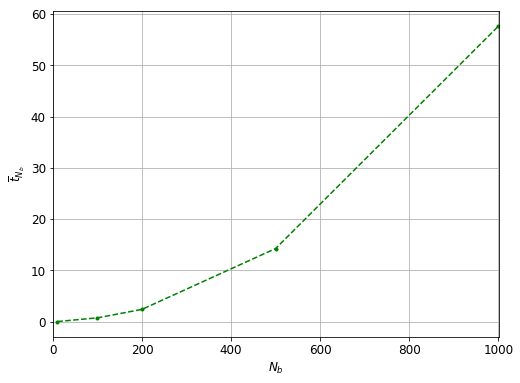

In [15]:
# TO HIDE

fig, ax = plt.subplots(1,1)
fig.set_size_inches(8,6)

ax.errorbar(overhead[:, 0], overhead[:, 1], yerr = overhead[:,2],
           color='green', marker='.', linestyle='dashed')
ax.grid(True)
ax.set_xlabel(r'$N_{b}$')
ax.set_ylabel(r'$\overline{t}_{N_{b}}$')
ax.set_xlim(0,1002)
plt.show()

#### Function evaluation

The speed of hashed and ordinary function evaluations are compared. To this end, we need to create a function that calculates the loss function of a segmentation without using the hash table. It comprises the following elements

1. Translate segmentation to list of hashes $\rightarrow$ `translate_segmentation`
1. Translate hash to (position, length) tuple $\rightarrow$ `hash_to_poslen`
1. Calculate the loss for each pattern $\rightarrow$ `calculate_pattern_cost`
1. Sum up the partial losses

The hash $\rightarrow$ tuple converter is easily built:

In [16]:
hash_to_poslen_ = dict(enumerate(hs.create_pattern_generator()))

Then it is glued together with the other components in the function ` calculate_loss_function_np`.

In [17]:
def  calculate_loss_function_np(segmentation, store, series, block_indices, hash_to_poslen):
    
    hash_keys = translate_segmentation(segmentation, store)
    gen_poslen = (hash_to_poslen[hash_] for hash_ in hash_keys)
    
    losses = (calculate_pattern_cost(pattern, series, block_indices) for pattern in gen_poslen)
    loss = sum(losses)
    
    return loss

We compare the runtimes of the _hashed_ native _numpy_ algorithms for a selection of segmentations. The overhead is added to each hashed times.

In [18]:
n_segmentations = [100, 500, 1000, 5000, 10000]

In [21]:
times_eval_hash, times_eval_np = [], [] # storage for evaluation times 

for n_blocks in block_sizes:

    # create new hash table
    block_indices = calculate_block_indices(F, n_blocks)
    hs = HashBrown(F, n_blocks, calculate_pattern_cost, calculate_pattern_hash,
                    func_args = [block_indices], hfunc_args = [n_blocks])

    hs.create_table()
    hash_table = hs.table
    hash_to_poslen = dict(enumerate(hs.create_pattern_generator()))
    
    store = np.zeros(n_blocks, dtype = np.int)
    
    # measurement on population
    for n_segmentation in n_segmentations:
        
        # create a segmentation <-- do not count time needed to generate this
        population = np.random.binomial(1, p = 0.9, size = (n_segmentation, n_blocks - 1))
    
        # 1) evalutating segmentation using hash table
        # (this is an extremely dirty way to evaluate a function repeatedly on a sequence of arguments)
        gen_ = (calculate_loss_function(segmentation, store, hash_table) for segmentation in population)
        func_ = lambda : sum(gen_)
        
        tmr = SlimTimer(func = func_, n_runs = 1)
        tmr.measure()
        times_eval_hash.append((n_blocks, n_segmentation, tmr.tmean))
        
        # 2) evalutating segmentation using numpy functions
        gen_ = (calculate_loss_function_np(segmentation, store, F, block_indices, hash_to_poslen) 
                for segmentation in population)
        func_ = lambda : sum(gen_)
        
        tmr = SlimTimer(func = func_, n_runs = 1)
        tmr.measure()
        times_eval_np.append((n_blocks, n_segmentation, tmr.tmean))

teh = np.array(times_eval_hash)
ten = np.array(times_eval_np)

The hashed evaluation is much faster than the native `numpy` one even when the overhead is included in the runtimes. The only exception happens where a small number of long strings are evaluated.

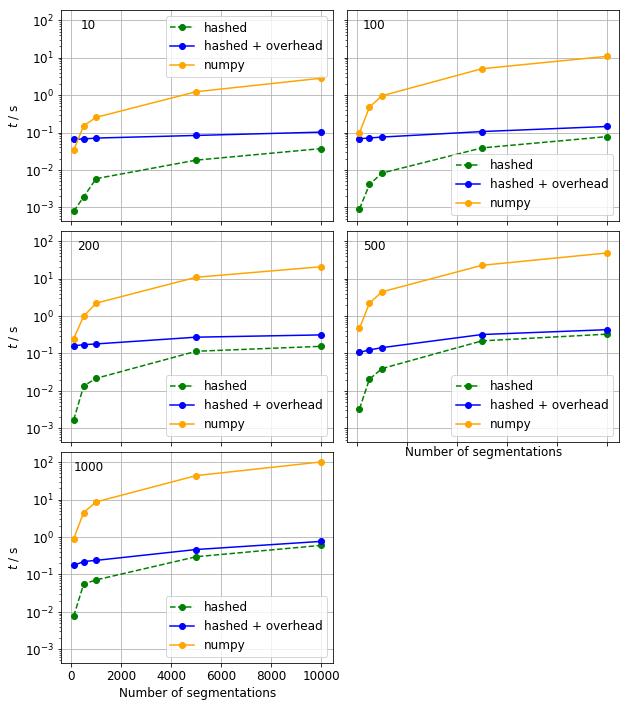

In [22]:
# TO HIDE

fig, axes = plt.subplots(3,2, sharex = True, sharey = True,
                         gridspec_kw = {'hspace' : 0.05, 'wspace' : 0.05})
fig.set_size_inches(10,12)

for idx, (ax, n_blocks) in enumerate(zip(axes.flat, block_sizes)):
    i_start = idx * len(block_sizes)
    i_end = (idx + 1) * len(block_sizes)

    ax.grid(True)
    ax.set_yscale('log')

    ax.plot(teh[i_start:i_end, 1], teh[i_start:i_end, 2], 
            marker = 'o', c = 'green', label = 'hashed', linestyle = '--')

    ax.plot(teh[i_start:i_end, 1], teh[i_start:i_end, 2] + overhead[idx,2] , 
            marker = 'o', c = 'blue', label = 'hashed + overhead')
    
    ax.plot(ten[i_start:i_end, 1], ten[i_start:i_end, 2], 
            marker = 'o', c = 'orange', label = 'numpy')
    
    ax.text(0.1, 0.9, str(n_blocks),
        verticalalignment = 'bottom', horizontalalignment = 'center',
        transform = ax.transAxes)
    
    ax.legend()
axes[2,0].set_xlabel('Number of segmentations')
axes[1,1].set_xlabel('Number of segmentations')
axes[0,0].set_ylabel(r'$t$ / s')
axes[1,0].set_ylabel(r'$t$ / s')
axes[2,0].set_ylabel(r'$t$ / s')
axes[-1,-1].axis('off')
plt.show()

## Final remarks

Hashing the loss function speeds up its evaluation with orders of magnitude. The computational bottleneck moves in to the creation of the hash table. A possible solution might be populating the hash table on-the-fly, rather than beforehand the optimisation.